In [1]:
import logging
import re
import pandas as pd
import numpy as np

from dataclasses import dataclass
from datetime import date, datetime, timezone, timedelta
from typing import Dict, List
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import ASYNCHRONOUS
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
from termcolor import colored

#from scc_co2_buz.domain.models.well_data import IO
from scc_co2_buz.helpers.utils.io_normalize import db_types 
from scc_co2_buz.helpers.utils.get_utc import get_utc_now
from scc_co2_buz.domain.models.tag import TagModel

In [2]:
# due to changes during tests some well tags are changed
map_to_tag = {'9-BUZ-11-RJS': 'well injection C', 
              '9-BUZ-35-RJS':'well injection D',
              '9-BUZ-3-RJS':'well injection C',
              '9-BUZ-4-RJS':'well injection D'}

class InfluxDbConfig:
    """"
    ConfigClass for InfluxDb
    """
    def __init__(self) -> None:
        self.url = "http://10.136.226.25:8086"
        self.token = "ganimede@2050"
        self.org = "PETROBRAS"
        self.bucket = "vip"
        self.write_options = ASYNCHRONOUS

class InfluxDBadapter:
    def __init__(self, config: InfluxDbConfig) -> None:
        self.config = config
        self.client = InfluxDBClient(config.url, config.token, debug=None, org=config.org)
        self.log = logging.getLogger(name='repository')
        print("connecting to P-77 database...")
    def closeConnection(self):
        self.client.close()
        self.log.info('connection to database closed')
    def AddTag(self, tag: TagModel) -> Dict[bool, Exception]:
        try:
            _point = self.makeTagPoint(tag)
            self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, record=[_point], org=self.config.org)
            self.log.info('tag ' + tag.tag + ' sent to database')

        except Exception as e:
            msg = 'error sending tag ' + tag.tag + ' to database ' + e.args
            self.log.error(msg)
            return None, e
        return (True, None)

    def addAllTags(self, tags: List[TagModel]) -> Dict[bool, Exception]:
        try:
            points = [self.makeTagPoint(t) for t in tags]
            db = self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, org=self.config.org, record=points)
            db.get()
        except Exception as e:
            msg = 'error sending tags to database ' + str(e)
            self.log.error(msg)
            return None, e
        return (True, None)

    def makeTagPoint(self, tag: List[TagModel]) -> Point:
        tag_field = 'DIAGNOSTIC' if tag.io in [
            IO.HEARTBEAT, IO.GENERALDIAG] else 'well'
        return Point("IO").tag(tag_field, tag.wn).field(tag.io, db_types[tag.io](tag.value)).time(tag.timestamp)

    def getData(self, start: date, end: date, tags:[TagModel] = None) -> DataFrame:
        params = {
            "start":  datetime.fromtimestamp(datetime.timestamp(start), tz=timezone.utc),
            "stop": datetime.fromtimestamp(datetime.timestamp(end), tz=timezone.utc),
            "bucket": self.config.bucket
        }
        filter_io = ''
        db_cols = list(set([tag.io for tag in tags]))
        for io in db_cols:
            if io != db_cols[-1]:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\" or '
            else:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\"'
        query = 'from(bucket: bucket)\
            |> range(start: start, stop: stop)\
            |> filter(fn: (r) => r["_measurement"] == "IO")\
            |> filter(fn: (r) => ' + filter_io + ')\
            |> yield(name: "last")'
        query_api = self.client.query_api()
        result = query_api.query(
            org=self.config.org, query=query, params=params)
        results = []
        for table in result:
            for record in table.records:
                results.append((datetime.fromtimestamp(
                    record.get_time().timestamp(), tz=timezone.utc), record.get_value(), record['well'], record.get_field()))
        df = pd.DataFrame(data=results, columns=['time', 'value', 'oil_well', 'io'])
        df2 = df.pivot(index=['time', 'oil_well'], columns=['io'], values=['value']).reset_index()
        df2.columns = [c[{'time': 0, 'oil_well': 0, 'value': 1}[c[0]]] for c in df2.columns]
        return df2
    
@dataclass
class Color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = "\033[1;32;48m"
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

def print_colored(msg:str, color: Color = Color.GREEN):
    print("{} {} {}".format(color,msg, Color.END))
def calcNormStd(df, well, pit, delta = timedelta(seconds=60)):
    start = df['time'].min()
    end = start + delta
    max_norm_std = -1.0
    
    time_limit = df.iloc[-1]['time'] - delta
    iteration = 0
    total_iterations = int((time_limit.timestamp() - start.timestamp()) / 60 )    
    values = []
    iterations = []
    #time_limit = 1000 * delta + start
    max_sample_data = None
    
    while start <= time_limit:
        mask = (df['oil_well'] == well) & (df['time'] >= start) & (df['time'] < end) 
        current_data = df.loc[mask][pit]
        current_norm_std = current_data.std() / current_data.mean()
        iteration += 1
        clear_output(wait=True)
        msg = f'iteration = {iteration} \n > progress = {100*iteration/total_iterations if iteration < total_iterations else 100.00} %'
        color = "green"
        print_colored(msg, Color.GREEN)
        if current_norm_std > max_norm_std:
            max_norm_std = current_norm_std 
            values.append(max_norm_std) 
            iterations.append(iteration)
            print(max_norm_std)
            max_sample_data = current_data
        start = start + delta
        end = end + delta
        
    df_std = pd.DataFrame({'iteration': iterations, 'variation': values})
    df_std.plot(x='iteration', y='variation', kind='line')
    plt.show()    
    return f'coefficient of variation = {100*max_norm_std} %'

def toFloat(x):
    
    if type(x) == float or type(x) == int:
        return x
    
    x = x.strip()
    x = x.replace(' ','')
    
    result1 = None
    result2 = None
    
    try:
        result1 = re.findall(r'\d+\.\d+', x)
        result2 = re.findall(r'\d+', x)
    except Exception as e:
        return np.nan
        
    if len(result1) > 0 and type(result1) == list:
        return float(result1[0])
    elif len(result2) > 0 and type(result2) == list:
        return float(result2[0])
    else:
        # comm fail from PI Web API
        return np.nan

def checkSupress(supression, time_):
    variation = 100 * ( supression.max() - supression.min() ) / (supression.mean() + 0.0000000001)
    if variation >= 2.0:
        print_colored(' > supressed by ' + supression.name + '\n  in time: ' + str(time_) + '\n  with variation : ' + str(variation) + ' %', Color.YELLOW)
        return True
    return False   

def normalize_data(df):
    
    for col in df.columns:
        if col not in ['time','oil_well']:
            if col.split('_')[0] in ['SDY', 'ZSH', 'ZSL' ]:
                df[col] = df[col].apply(lambda x: 1 if x  else 0)
            else:
                
                df[col] = df[col].apply(lambda x: toFloat(x))
                #std = df[col].std()
                #mean = df[col].mean()
                #df[col] = df[col].apply(lambda x: (x - mean) / (std + 0.000000000001))
        else:
            if col == 'time':
                df[col] = df[col].apply(lambda x: datetime.strptime(x.split('+')[0], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=3)) 

            
    #df = df.dropna()
    return df

class Signal:
    def __init__(self):
        self.io_input = []
        self.io_ouput = []
        self.alarm_values = [0,0,0,0,0,0]
        self.sample_values = [0,0,0,0,0,0]
        self.values = [0,0,0,0,0,0,0,0,0]
        
    def check_alarm(self, df, instrument_supress, time_, i, v, set_point_ll = -67 * 100):
        
        self.alarm_values.append(1.0 if v <= set_point_ll else 0.0 ) 
        self.alarm_values.pop(0)
        self.sample_values.append(v)
        self.sample_values.pop(0)  
        
        check = 0         

        if sum(self.alarm_values) == 6:   
    
            # select data for supression
            start = time_ - timedelta(seconds = 120) 
            end = time_
            
            ## code repetition for n supressions
            mask = (df[instrument_supress].notnull()) & (df['time'] >= start) & (df['time'] <= end)
            supression = df.loc[mask][instrument_supress]
            
            print(supression)
            print_colored(f'{start} , {end}',Color.BLUE)
            
            # change check to 1 if supression is enable
            if not checkSupress(supression, time_):
                check = 1
                
            ## code repetition for n supressions
            
            # print alarm
            color = Color.RED if check == 1 else Color.GREEN
            print_colored('iter = '+ str(i), color)
            print_colored('time = '+ str(time_), color)
            print_colored('signal inputs '+ str(self.values) + ' kPa', color)
            print_colored('signal outputs'+ str(self.sample_values) + ' kPa/min',color)
            self.alarm_values = [0,0,0,0,0,0]
            self.sample_values = [0,0,0,0,0,0]
       
        
        return check
    
    def signalFilter(self,df,instrument,instrument_supress,coef = [-4,-3,-2,-1,0,1,2,3,4],gain = 1.0):
        
        delta_sec = 5       
        mask = df[instrument].notnull()
        current_data = df.loc[mask][instrument]
        current_time = df.loc[mask]['time']
        
        total_iterations = int(len(current_data) * 1)
        iter_out = []
        status_in_alarm = 0
        alarms = []
        
        print_colored('total iterations ' + str(total_iterations), Color.BLUE )
        
        for i in range(total_iterations):
            iter_out.append(i)
            self.io_input.append(current_data.iloc[i]) 
            out_ = 0
            self.values.append(current_data.iloc[i])
            self.values.pop(0)
            for c, v in  zip(coef,self.values):
                out_  +=  c * v
            filtered = gain * out_ / delta_sec
            self.io_ouput.append(filtered) 
            alarms.append(self.check_alarm(df,instrument_supress, current_time.iloc[i], i, filtered))
        
        # plot fig size
        size = (18,6)
        # alarm
        alm = DataFrame({'time':iter_out,'alarms': alarms})
        alm.plot(x='time',y='alarms', kind='line', figsize=size)
        
        # input signal
        df_input = DataFrame({'time': iter_out, instrument: self.io_input})
        df_input.plot(x='time', y=instrument, kind='line', figsize=size)
        
        # supress signal
        mask = df[instrument_supress].notnull()
        df.loc[mask].plot(x='time', y=instrument_supress, kind='line', figsize=size)        
        
        # filtered signal
        result = DataFrame({'time':iter_out,'filtered_signal': self.io_ouput})
        result.plot(x='time',y='filtered_signal', kind='line', figsize=size)        
        
        # print alarms
        total_alarms = alm.sum().values[1]
        color = Color.RED if total_alarms >= 1 else Color.GREEN
        print_colored('total alarms =  ' + str(total_alarms), color)
        
        return result 

def merge_cols(df):
    
    df['ZIT_1244002'] = df.apply( lambda x: x['ZIT_1244002_1'] if not np.isnan(x['ZIT_1244002_1']) else x['ZIT_1244002_2'] , axis=1)

    df['ZSH_1210002'] = df.apply(lambda x: x['ZSH_1210002_1'] if not np.isnan(x['ZSH_1210002_1']) else (x['ZSH_1210002_2'] if not np.isnan(x['ZSH_1210002_2']) else x['ZSH_1210002_3']) , axis=1)

    df = df.drop(['ZIT_1244002_1', 'ZIT_1244002_2' ,'ZSH_1210002_1', 'ZSH_1210002_2' , 'ZSH_1210002_3'], axis=1)
    
    return df
    
    
def make_well_data(df, wells=['well injection C',  'well injection D']):
   
    df_result = DataFrame()
    for well in wells:
        l = well.split(' ')[2]
        mask = (df['oil_well'] == well)
        df_result = df_result.append(DataFrame({
        'time' : df.loc[mask]['time'].values,
        'ZIT_1244002' + l: df.loc[mask]['ZIT_1244002'].values,
        'PIT_1244007' + l: df.loc[mask]['PIT_1244007'].values,
        'PIT_1244008' + l: df.loc[mask]['PIT_1244008'].values,
        'SDY_1210002' + l: df.loc[mask]['SDY_1210002'].values,
        'ZSH_1210002' + l: df.loc[mask]['ZSH_1210002'].values,
        'ZSL_1210002' + l: df.loc[mask]['ZSL_1210002'].values}))
    return df_result



In [3]:
columns = {'P-JUZ-CKP-A': "PIT_1244007", 
           'P-JUZ-CKP-B': "PIT_1244008",
           'ESTADO-POCO':'ZSH_1210002_1',
           'SDV':'ZSH_1210002_2',
           'ZSH': 'ZSH_1210002_3',
           'ZSL': 'ZSL_1210002',
           'ABER-CKP': 'ZIT_1244002_1',
           'CHOKE': 'ZIT_1244002_2',
           'CMD': 'SDY_1210002'}

tags = list( map( lambda io: TagModel(paths=None,tag=None, io=io), columns.keys()))
end = get_utc_now()
start = get_utc_now() - timedelta(seconds=60*60*24*18) #timedelta(seconds=259200)

In [5]:
repo = InfluxDBadapter(config=InfluxDbConfig())
df = repo.getData(start=start,end=end,tags=tags)

connecting to P-77 database...


In [6]:
mask = (df['oil_well'].apply(lambda v: v in map_to_tag.keys()))
df = df.loc[mask].copy()
df['oil_well'] = df['oil_well'].apply(lambda x: map_to_tag[x])
df = df.rename(columns=columns)
df_select = df.query('oil_well=="well injection C" or oil_well == "well injection D"')
df_select

,time,oil_well,ZIT_1244002_1,ZIT_1244002_2,SDY_1210002,ZSH_1210002_1,PIT_1244007,PIT_1244008,ZSH_1210002_2,ZSH_1210002_3,ZSL_1210002
4,2022-11-15 11:21:28.093245+00:00,well injection D,40.243752,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
9,2022-11-15 11:22:24.014866+00:00,well injection D,40.243752,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
14,2022-11-15 11:23:28.009258+00:00,well injection D,40.237499,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
19,2022-11-15 11:24:23.940348+00:00,well injection D,40.237499,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
24,2022-11-15 11:25:27.098022+00:00,well injection D,40.237499,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1005306,2022-12-03 11:21:02.700539+00:00,well injection C,NaN,10.325,True,NaN,30519.970703,30631.609375,NaN,False,False
1005307,2022-12-03 11:21:02.700539+00:00,well injection D,NaN,NaN,True,NaN,43203.710938,43156.480469,NaN,True,NaN
1005308,2022-12-03 11:21:15.089605+00:00,well injection D,NaN,24.53125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005309,2022-12-03 11:21:16.146274+00:00,well injection C,NaN,10.31875,True,NaN,30472.740234,30588.669922,NaN,False,False


In [7]:
df_select.to_csv("output_data.csv", index= False)
#calcNormStd(df, 'well injection D', 'PIT_1244008')

In [8]:
df = pd.read_csv("output_data.csv",low_memory=False)

In [9]:
df = normalize_data(df)
df = merge_cols(df)
df = make_well_data(df)
df

,time,ZIT_1244002C,PIT_1244007C,PIT_1244008C,SDY_1210002C,ZSH_1210002C,ZSL_1210002C,ZIT_1244002D,PIT_1244007D,PIT_1244008D,SDY_1210002D,ZSH_1210002D,ZSL_1210002D
0,2022-11-16 20:45:11.634515,NaN,29536.699219,29639.750000,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-16 20:45:17.197659,NaN,29523.820312,29626.869141,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-16 20:45:22.637574,NaN,29532.410156,29639.750000,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-16 20:45:28.110124,NaN,29541.000000,29644.050781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-16 20:45:33.322788,NaN,29532.410156,29639.750000,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313576,2022-12-03 08:20:49.312552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43216.593750,43165.058594,1.0,1.0,1.0
313577,2022-12-03 08:21:01.602214,NaN,NaN,NaN,NaN,NaN,NaN,24.53125,NaN,NaN,1.0,1.0,1.0
313578,2022-12-03 08:21:02.700539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43203.710938,43156.480469,1.0,1.0,1.0
313579,2022-12-03 08:21:15.089605,NaN,NaN,NaN,NaN,NaN,NaN,24.53125,NaN,NaN,1.0,1.0,1.0


 total iterations 184305 
32969    40.356251
32981    40.356251
Name: ZIT_1244002D, dtype: float64
 2022-11-18 15:07:49.347342 , 2022-11-18 15:09:49.347342 
 iter = 28257 
 time = 2022-11-18 15:09:49.347342 
 signal inputs [39326.44921875, 38609.3984375, 37888.046875, 37256.859375, 36638.55859375, 36131.8984375, 35633.83203125, 35208.75390625, 34783.66015625] kPa 
 signal outputs[-7186.0234375, -7662.63515625, -7842.11171875, -7720.1671875, -7331.14609375, -6801.29609375] kPa/min 
51756    43.181252
51768    43.181252
Name: ZIT_1244002D, dtype: float64
 2022-11-19 17:06:17.422668 , 2022-11-19 17:08:17.422668 
 iter = 45491 
 time = 2022-11-19 17:08:17.422668 
 signal inputs [43985.16796875, 43302.4609375, 42435.12890625, 41310.16015625, 39979.1015625, 38824.078125, 37973.921875, 37235.3984375, 36587.0390625] kPa 
 signal outputs[-7698.696875, -9113.915625, -10402.04453125, -11232.45390625, -11715.06875, -11840.43984375] kPa/min 
51937    43.1875
51949    43.1875
Name: ZIT_1244002D, dty

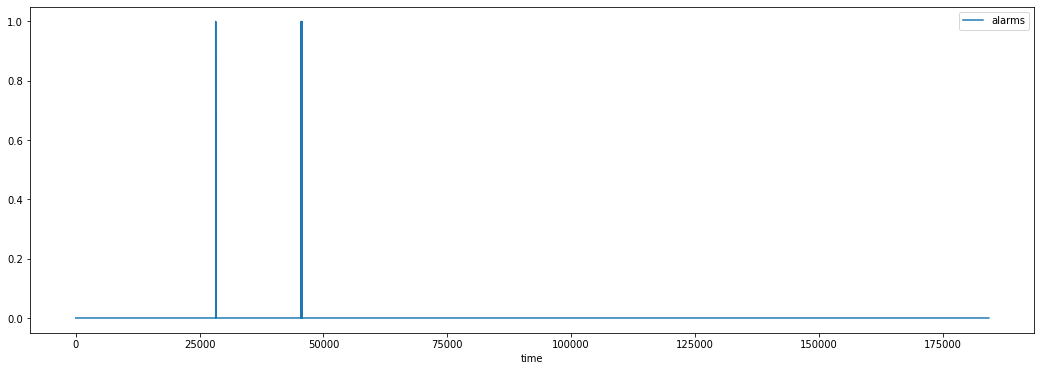

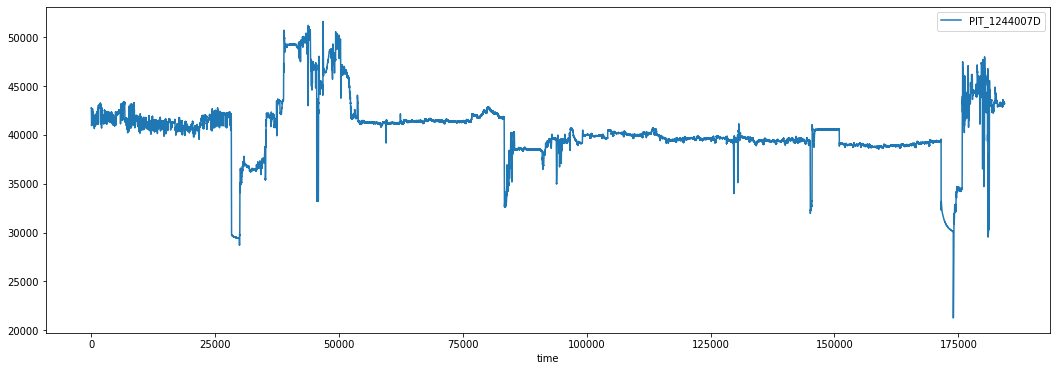

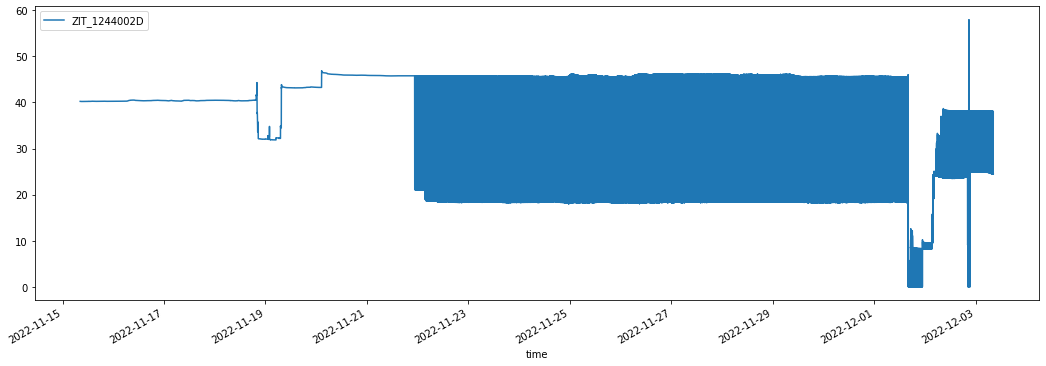

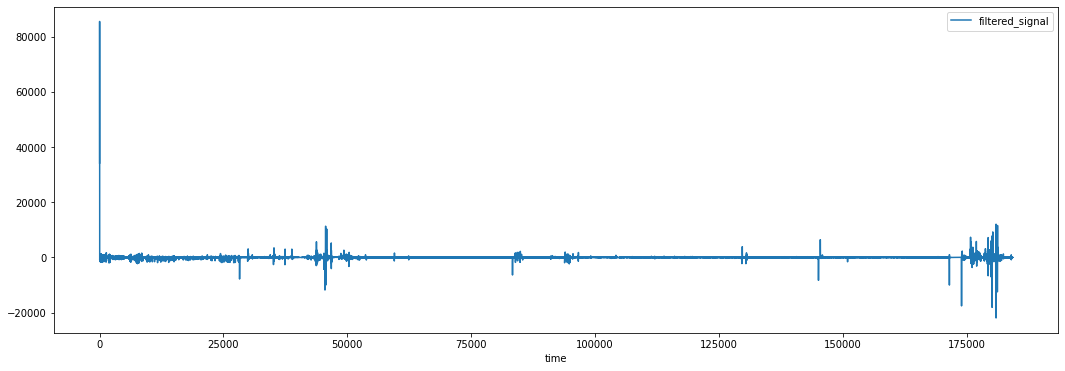

In [10]:
result = Signal().signalFilter(df,'PIT_1244007D' ,'ZIT_1244002D')

 total iterations 184305 
Series([], Name: ZIT_1244002C, dtype: float64)
 2022-11-18 17:24:27.522296 , 2022-11-18 17:26:27.522296 
 iter = 29774 
 time = 2022-11-18 17:26:27.522296 
 signal inputs [40824.96875, 40824.96875, 37196.75390625, 29004.279296875, 28879.759765625, 29300.55078125, 29167.439453125, 29124.5, 29382.130859375] kPa 
 signal outputs[-11512.40078125, -18113.609765625, -21850.026171875, -23386.330078125, -22628.05859375, -19327.023046875] kPa/min 
174053    0.0
174054    0.0
174055    0.0
174056    0.0
174057    0.0
174058    0.0
174059    0.0
174060    0.0
174061    0.0
174062    0.0
174063    0.0
174064    0.0
Name: ZIT_1244002C, dtype: float64
 2022-12-01 22:40:32.679232 , 2022-12-01 22:42:32.679232 
 iter = 174064 
 time = 2022-12-01 22:42:32.679232 
 signal inputs [34126.71875, 34178.24609375, 34229.76953125, 20605.69921875, 20816.099609375, 20644.349609375, 20803.2109375, 20682.990234375, 20751.689453125] kPa 
 signal outputs[-10336.7734375, -18411.5984375, -2395

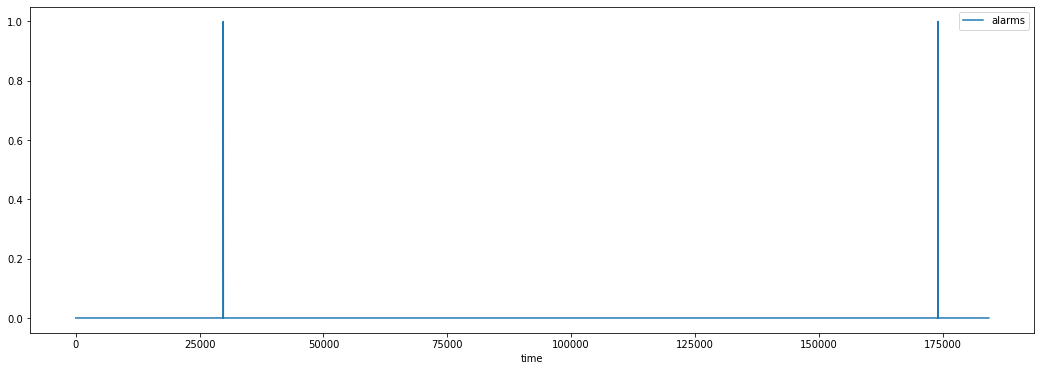

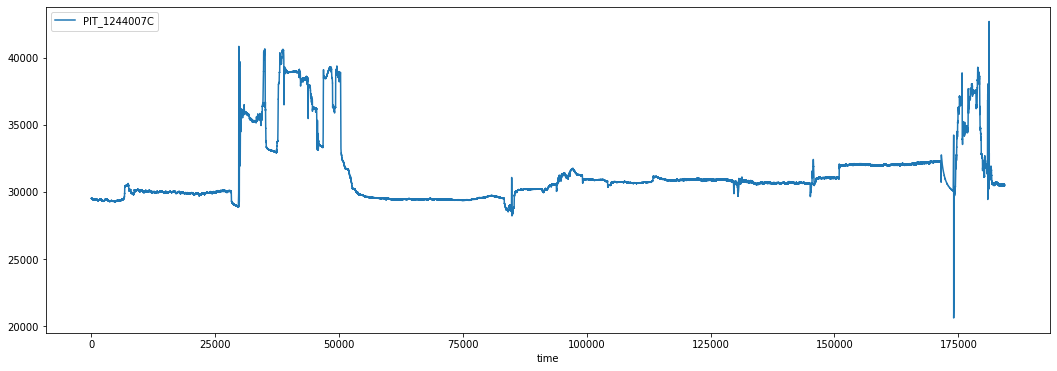

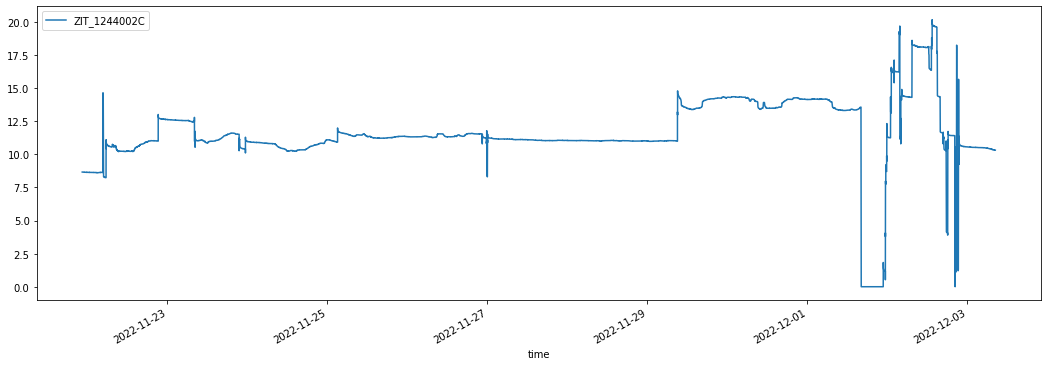

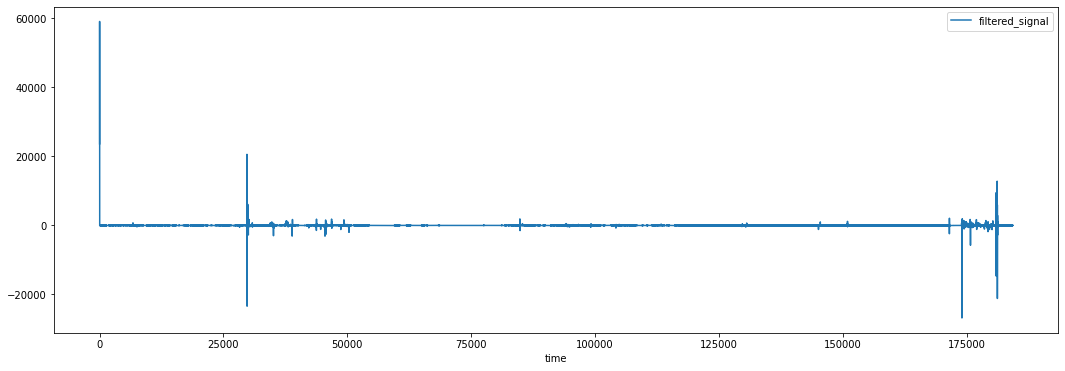

In [11]:
result = Signal().signalFilter(df,'PIT_1244007C' , 'ZIT_1244002C')